# Detecting BDM In Superbowl Commercials

In [45]:
import pandas as pd
import os

In [ ]:

%pip install -r requirements.txt

In [1]:
INDUSTRY_SPECIFIC_AWARENESS = False
BRAND_SPECIFIC_AWARENESS = False

# Donwload Ads


In [ ]:
# Define the URL and the target directory
url = 'https://box.fu-berlin.de/s/zwxKp8PXkCwAwGe/download'
download_filename = 'downloaded_archive.zip'
target_directory = 'ADs'

# Step 1: Download the file
os.system(f'wget -O {download_filename} {url}')

# Step 2: Create the target directory if it doesn't exist
os.makedirs(target_directory, exist_ok=True)

# Step 3: Extract the downloaded archive to the target directory
os.system(f'unzip -o {download_filename} -d {target_directory}')

# Step 4: Remove the downloaded file
os.remove(download_filename)

print(f"Archive extracted to {target_directory} and {download_filename} removed.")

# Merge Excel Files

In [3]:
BDM_excel = pd.read_excel('BDM.xlsx')
final_excel = pd.read_excel('previous_project_results.xlsx')

In [ ]:
final_excel = final_excel.merge(
    BDM_excel[['AdNumber', 'BDM']], 
    on='AdNumber', 
    how='left',
    suffixes=('_old', '')
).drop('BDM_old', axis=1, errors='ignore')


# print number of rows where BDM is NaN, 0 and 1
print(f"Number of rows where BDM is NaN: {final_excel[final_excel['BDM'].isna()].shape[0]}")
print(f"Number of rows where BDM is 0: {final_excel[final_excel['BDM'] == 0].shape[0]}")
print(f"Number of rows where BDM is 1: {final_excel[final_excel['BDM'] == 1].shape[0]}")


In [ ]:
ad_df = final_excel.groupby(['cont_primary_product_type', 'BRAND', 'AdNumber', "BDM"]).size().reset_index(name='count')
ad_df.rename(columns={'cont_primary_product_type': 'product_category', 'BRAND': 'brand', 'AdNumber': 'commercial_number'}, inplace=True)
ad_df.drop(columns=['count'], inplace=True)
ad_df.head(10)

### Brand Keywords

In [52]:
if BRAND_SPECIFIC_AWARENESS:
    product_brand_df = pd.read_csv("product_brands.csv")

    product_brand_df['brand'] = product_brand_df['brand'].str.replace(' ', '').str.lower()
    ad_df['brand_clean'] = ad_df['brand'].str.replace(' ', '').str.lower()

    # Merge the dataframes
    ad_df = ad_df.merge(
        product_brand_df[['brand', 'product_brand_keywords']], 
        left_on='brand_clean',
        right_on='brand',
        how='left',
        suffixes=('', '_brand')
    )

    # Clean up columns
    ad_df.drop(['brand_clean', 'brand_brand'], axis=1, inplace=True)


    ad_df.head(10)

### Product Category Keywords

In [53]:
if INDUSTRY_SPECIFIC_AWARENESS:
    product_brands_df = pd.read_csv("product_categories.csv")
    product_brands_df.head(40)
    product_brands_df = product_brands_df.drop('product_cat_id', axis=1)
    ad_df = ad_df.drop('product_category', axis=1)
    display(product_brands_df)
    display(ad_df)

    # Create a dictionary to map brands to their product categories and other attributes
    brand_to_info = {}
    for _, row in product_brands_df.iterrows():
        # Convert string representation of list to actual list
        brands = eval(row['product_cat_brands'])
        for brand in brands:
            # Remove spaces and convert to lowercase for more robust matching
            brand = brand.replace(' ', '').lower()
            # Store all columns for this brand
            brand_to_info[brand] = {col: row[col] for col in product_brands_df.columns}

    # Function to find category info for a brand
    def find_brand_info(brand):
        # Clean brand name for matching
        clean_brand = brand.replace(' ', '').lower()
        return brand_to_info.get(clean_brand)

    # Add all product category columns to ad_df
    for col in product_brands_df.columns:
        ad_df[col] = ad_df['brand'].apply(lambda x: find_brand_info(x)[col] if find_brand_info(x) else None)

    # Print brands that couldn't be mapped
    unmapped_brands = ad_df[ad_df['product_cat_name'].isna()]['brand'].unique()
    if len(unmapped_brands) > 0:
        print("Brands without category mapping:")
        for brand in unmapped_brands:
            print(f"- {brand}")

    # Print number of rows with missing category
    print(f"Number of rows where product category is NaN: {ad_df[ad_df['product_cat_name'].isna()].shape[0]}")


    print(f"Final number of rows with missing categories: {ad_df[ad_df['product_cat_name'].isna()].shape[0]}")

    ad_df.head(10)

In [ ]:
ad_df = ad_df.dropna()
# TODO: Implement proper handling of missing values
# TODO: Remove this line
ad_df = ad_df.head(5)
display(ad_df)

# save progress so far to csv
ad_df.to_csv('csvs/1_ad_df_baseline.csv', index=False)

## Retrieving Transcript

In [55]:
ad_df = pd.read_csv('csvs/1_ad_df_baseline.csv')

In [ ]:
import glob
from pathlib import Path
from transcript import transcribe_video

ads_dir = "ADs"

def find_video_file(commercial_number, ads_dir):
    """Find the video file path for a given commercial number."""
    # Search recursively for MP4 files
    pattern = f"{ads_dir}/**/{commercial_number}.mp4"
    matches = glob.glob(pattern, recursive=True)
    return matches[0] if matches else None

# Create transcript column
ad_df['transcript'] = ''

# Process each commercial
for idx, row in ad_df.iterrows():
    commercial_number = row['commercial_number']
    video_path = find_video_file(commercial_number, ads_dir)
    
    if video_path:
        transcript = transcribe_video(video_path)
        ad_df.at[idx, 'transcript'] = transcript
    else:
        print(f"Video not found for commercial {commercial_number}")

ad_df[ad_df['transcript'].notna()]
ad_df["audio_only_transcript"] = ad_df["transcript"]
ad_df.head(10)

In [57]:

ad_df.to_csv('csvs/2_ad_df_transcript.csv', index=False)

## Adding OCR Text

In [58]:
ad_df = pd.read_csv('csvs/2_ad_df_transcript.csv')

In [59]:

# from ocr import ocr

In [60]:


ad_df['ocr_text'] = ''

ad_df.drop(columns=['ocr_text'], inplace=True)
for idx, row in ad_df.iterrows():
    transcript = row['transcript']

    ad_df.at[idx, 'ocr_text'] = 'NOT IMPLEMENTED YET'
    # TODO Uncomment the line below to run OCR on the transcript
    # ad_df.at[idx, 'ocr_text'] = ocr(transcript)

ad_df["audio_only_transcript"] = ad_df["transcript"]
ad_df['transcript'] = ad_df['ocr_text'] + ' ' + ad_df['transcript']
ad_df.head(10)


ad_df.to_csv('csvs/3_ad_df_ocr.csv', index=False)


In [ ]:
!python -m spacy download en_core_web_sm


# Determining Frequency of Superlatives and Comparative Adjectives

In [62]:

ad_df = pd.read_csv('csvs/3_ad_df_ocr.csv')

In [ ]:
import spacy
import pandas as pd
from collections import Counter
import text_analysis as ta

# Create new columns to store the counts and percentages
ad_df['word_count'] = 0
ad_df['superlative_count'] = 0
ad_df['comparative_count'] = 0
ad_df['uniqueness_count'] = 0
ad_df['superlative_pct'] = 0.0
ad_df['comparative_pct'] = 0.0
ad_df['uniqueness_pct'] = 0.0
ad_df['total_bdm_terms_count'] = 0
ad_df['total_bdm_terms_pct'] = 0.0

# Process each row
for idx, row in ad_df.iterrows():
    word_count = len(ta.get_tokens(row['transcript']))
    ad_df.at[idx, 'word_count'] = word_count

    superlatives = ta.get_superlatives(row['transcript'])
    ad_df.at[idx, 'superlatives'] = ', '.join(superlatives) if superlatives else ''
    superlative_count = len(superlatives) if superlatives else 0
    ad_df.at[idx, 'superlative_count'] = superlative_count

    comparatives = ta.get_comparatives(row['transcript'])
    ad_df.at[idx, 'comparatives'] = ', '.join(comparatives) if comparatives else ''
    comparative_count = len(comparatives) if comparatives else 0
    ad_df.at[idx, 'comparative_count'] = comparative_count
    
    unique_words = ta.get_unique_words(row['transcript'])
    ad_df.at[idx, 'unique_words'] = ', '.join(unique_words) if unique_words else ''
    uniqueness_count = len(unique_words) if unique_words else 0
    ad_df.at[idx, 'uniqueness_count'] = uniqueness_count

    if word_count > 0:
        ad_df.at[idx, 'superlative_pct'] = superlative_count / word_count * 100
        ad_df.at[idx, 'comparative_pct'] = comparative_count / word_count * 100
        ad_df.at[idx, 'uniqueness_pct'] = uniqueness_count / word_count * 100
        
        total_bdm_terms = superlative_count + comparative_count + uniqueness_count
        ad_df.at[idx, 'total_bdm_terms_count'] = total_bdm_terms
        ad_df.at[idx, 'total_bdm_terms_pct'] = total_bdm_terms / word_count * 100

# Sort the DataFrame
ad_df = ad_df.sort_values(
    by=['superlative_count', 'comparative_count', 'superlative_pct', 'comparative_pct', 'uniqueness_pct'],
    ascending=[False, False, False, False, False]
)

# Display top 10 results
ad_df.head(10)

In [ ]:
# remove superlatives, comparatives and unique_words from ad_df
ad_df.drop(columns=['comparative_pct', 'superlative_pct', 'uniqueness_pct'], inplace=True)
ad_df.head(10)


## Nomen + Adjektive

In [ ]:
# Apply the function to each transcript individually using pandas apply
ad_df["adj_noun_pairs"] = ad_df["transcript"].apply(ta.extract_adj_noun_pairs)

# Add a column for the number of adjective-noun pairs
ad_df["num_adj_noun_pairs"] = ad_df["adj_noun_pairs"].apply(len)

# Display the first 10 rows of the DataFrame
display(ad_df.head(10))

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import defaultdict

nltk.download('all')


In [67]:
# Process each transcript
import numpy as np
if INDUSTRY_SPECIFIC_AWARENESS:
    for idx, row in ad_df.iterrows():
        transcript = row['transcript']
        product_cat_keyword_similarities = {}
        for keyword in row['product_cat_keywords'][1:-1].replace("'", "").split(", "):
            similarity = round(float(ta.get_semantic_similarity(transcript, keyword)), 3)
            product_cat_keyword_similarities[keyword] = similarity
        
        sorted_keywords = sorted(product_cat_keyword_similarities.items(), key=lambda x: x[1], reverse=True)
        top_3_keywords = sorted_keywords[:3]
        top_3_average = round(float(np.mean([sim for _, sim in top_3_keywords])), 3)
        
        print(f"\nTranscript {row['commercial_number']}:")
        print(f"Top 3 keywords:")
        for keyword, similarity in top_3_keywords:
            print(f"- {keyword}: {similarity}")
        print(f"Top 3 average similarity: {top_3_average}")
        
        ad_df.at[idx, 'product_cat_keyword_similarity'] = top_3_average
        ad_df.at[idx, 'product_cat_top_keywords'] = ', '.join([keyword for keyword, _ in top_3_keywords])
if BRAND_SPECIFIC_AWARENESS:
    for idx, row in ad_df.iterrows():
        transcript = row['transcript']
        product_brand_keyword_similarities = {}
        
        for keyword in row['product_brand_keywords'][1:-1].replace("'", "").split(", "):
            similarity = round(float(ta.get_semantic_similarity(transcript, keyword)), 3)
            product_brand_keyword_similarities[keyword] = similarity
        
        sorted_keywords = sorted(product_brand_keyword_similarities.items(), key=lambda x: x[1], reverse=True)
        top_3_keywords = sorted_keywords[:3]
        top_3_average = round(float(np.mean([sim for _, sim in top_3_keywords])), 3)
        
        print(f"\nTranscript {row['commercial_number']}:")
        print(f"Top 3 brand keywords:")
        for keyword, similarity in top_3_keywords:
            print(f"- {keyword}: {similarity}")
        print(f"Top 3 average brand similarity: {top_3_average}")
        
        ad_df.at[idx, 'product_brand_keyword_similarity'] = top_3_average
        ad_df.at[idx, 'product_brand_top_keywords'] = ', '.join([keyword for keyword, _ in top_3_keywords])

In [68]:

ad_df.to_csv('csvs/4_ad_df_keywords.csv', index=False)

In [69]:
import pandas as pd
ad_df = pd.read_csv('csvs/4_ad_df_keywords.csv')

In [ ]:


ad_df[ad_df.isnull().any(axis=1)].head()
ad_df[ad_df.isna().any(axis=1)].head()

ad_df = ad_df[ad_df['transcript'] != '']
ad_df = ad_df[ad_df['transcript'] != '']

# print all from ad_df with empty values
display(ad_df[ad_df.isnull().any(axis=1)])
display(ad_df[ad_df.isna().any(axis=1)])

In [ ]:
ad_df.head(20)

In [ ]:
# Calculate the minimum number of samples in each group
# 
min_samples = min(len(ad_df[ad_df['BDM'] == 1]), len(ad_df[ad_df['BDM'] == 0]))
nn_df = ad_df
# Perform undersampling
ad_df_balanced = pd.concat([
    ad_df[ad_df['BDM'] == 1].sample(n=min_samples, random_state=42),
    ad_df[ad_df['BDM'] == 0].sample(n=min_samples, random_state=42)
]).reset_index(drop=True)

# Print the results
print(f"Total rows: {len(ad_df_balanced)}")
print(f"Rows with BDM = 1.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 1.0])}")
print(f"Rows with BDM = 0.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 0.0])}")



commercial_numbers = ad_df_balanced['commercial_number']

# TODO: remove the following line after testing
ad_df_balanced = ad_df

ad_df_balanced.head(20)

## Ansatz 1 (Machine learning)

In [ ]:
# Print available columns
print("Available columns:")
print(ad_df_balanced.columns.tolist())

In [ ]:

display(ad_df_balanced)


In [75]:
ad_df_balanced.to_csv('csvs/5_ad_df_balanced.csv', index=False)

In [2]:
import pandas as pd
ad_df_balanced = pd.read_csv('csvs/5_ad_df_balanced.csv')


Tuning Logistic Regression...
Best parameters: {'C': np.float64(0.10778765841014329), 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.250

Tuning Decision Tree...
Best parameters: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best score: 0.500

Tuning Random Forest...
Best parameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 253}
Best score: 1.000

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.12236203565420874), 'max_depth': 7, 'n_estimators': 64}
Best score: 1.000

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(7.5908023769472495), 'kernel': 'rbf'}
Best score: 1.000
Training Majority Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training AdaBoost...
Saving Majority Classifier to trained_models/majority_classifier.pkl
Saving Logistic Regression to 

/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicte

Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/.v

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0525,1.0,"NOT IMPLEMENTED YET Well, we didn't. We seale...","Well, we didn't. We sealed the bad out and ke...",NOT IMPLEMENTED YET,98,1,0,0,1,1.020408,hottest,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0474,0.0,"NOT IMPLEMENTED YET Guys, how can we be a sec...","Guys, how can we be a secret society if we ca...",NOT IMPLEMENTED YET,125,1,0,1,2,1.600000,least,NaN,only,"['secret society', 'good fat', 'secret society...",4
2,1.0,AvocadosfromMexico,AD0357,0.0,NOT IMPLEMENTED YET With an ex-pick in the fi...,"With an ex-pick in the first draft ever, Aust...",NOT IMPLEMENTED YET,80,0,0,2,2,2.500000,NaN,NaN,"first, original","['first draft', 'ideal year']",2
3,1.0,AvocadosfromMexico,AD0584,1.0,"NOT IMPLEMENTED YET Pagentry, poise, welcome ...","Pagentry, poise, welcome to the Doge Show whe...",NOT IMPLEMENTED YET,110,0,0,1,1,0.909091,NaN,NaN,ultimate,"['ultimate prize', 'good sit']",2
4,1.0,AvocadosfromMexico,AD0414,1.0,NOT IMPLEMENTED YET Over here we have the cub...,Over here we have the cube of Rubik. This sim...,NOT IMPLEMENTED YET,106,0,0,0,0,0.000000,NaN,NaN,NaN,"['simple puzzle', '21st century', 'civil war']",3


Cross-Validation Results:



| Model                  |   ROC AUC (Mean) |   ROC AUC (Std) |   Accuracy (Mean) |   Accuracy (Std) |   Precision (Mean) |   Precision (Std) |   Recall (Mean) |   Recall (Std) |
|:-----------------------|-----------------:|----------------:|------------------:|-----------------:|-------------------:|------------------:|----------------:|---------------:|
| Support Vector Machine |             1    |            0    |          0.75     |        0.25      |               0.75 |              0.25 |             1   |            0   |
| Gradient Boosting      |             1    |            0    |          1        |        0         |               1    |              0    |             1   |            0   |
| Random Forest          |             1    |            0    |          0.75     |        0.25      |               0.75 |              0.25 |             1   |            0   |
| AdaBoost               |             1    |            0    |          1        |        0         |               1    |              0    |             1   |            0   |
| Majority Classifier    |             0.5  |            0    |          0.416667 |        0.0833333 |               0.25 |              0.25 |             0.5 |            0.5 |
| Decision Tree          |             0.5  |            0    |          0.416667 |        0.0833333 |               0.25 |              0.25 |             0.5 |            0.5 |
| Logistic Regression    |             0.25 |            0.25 |          0.416667 |        0.0833333 |               0    |              0    |             0   |            0   |
| K-Nearest Neighbors    |           nan    |          nan    |        nan        |      nan         |             nan    |            nan    |           nan   |          nan   |

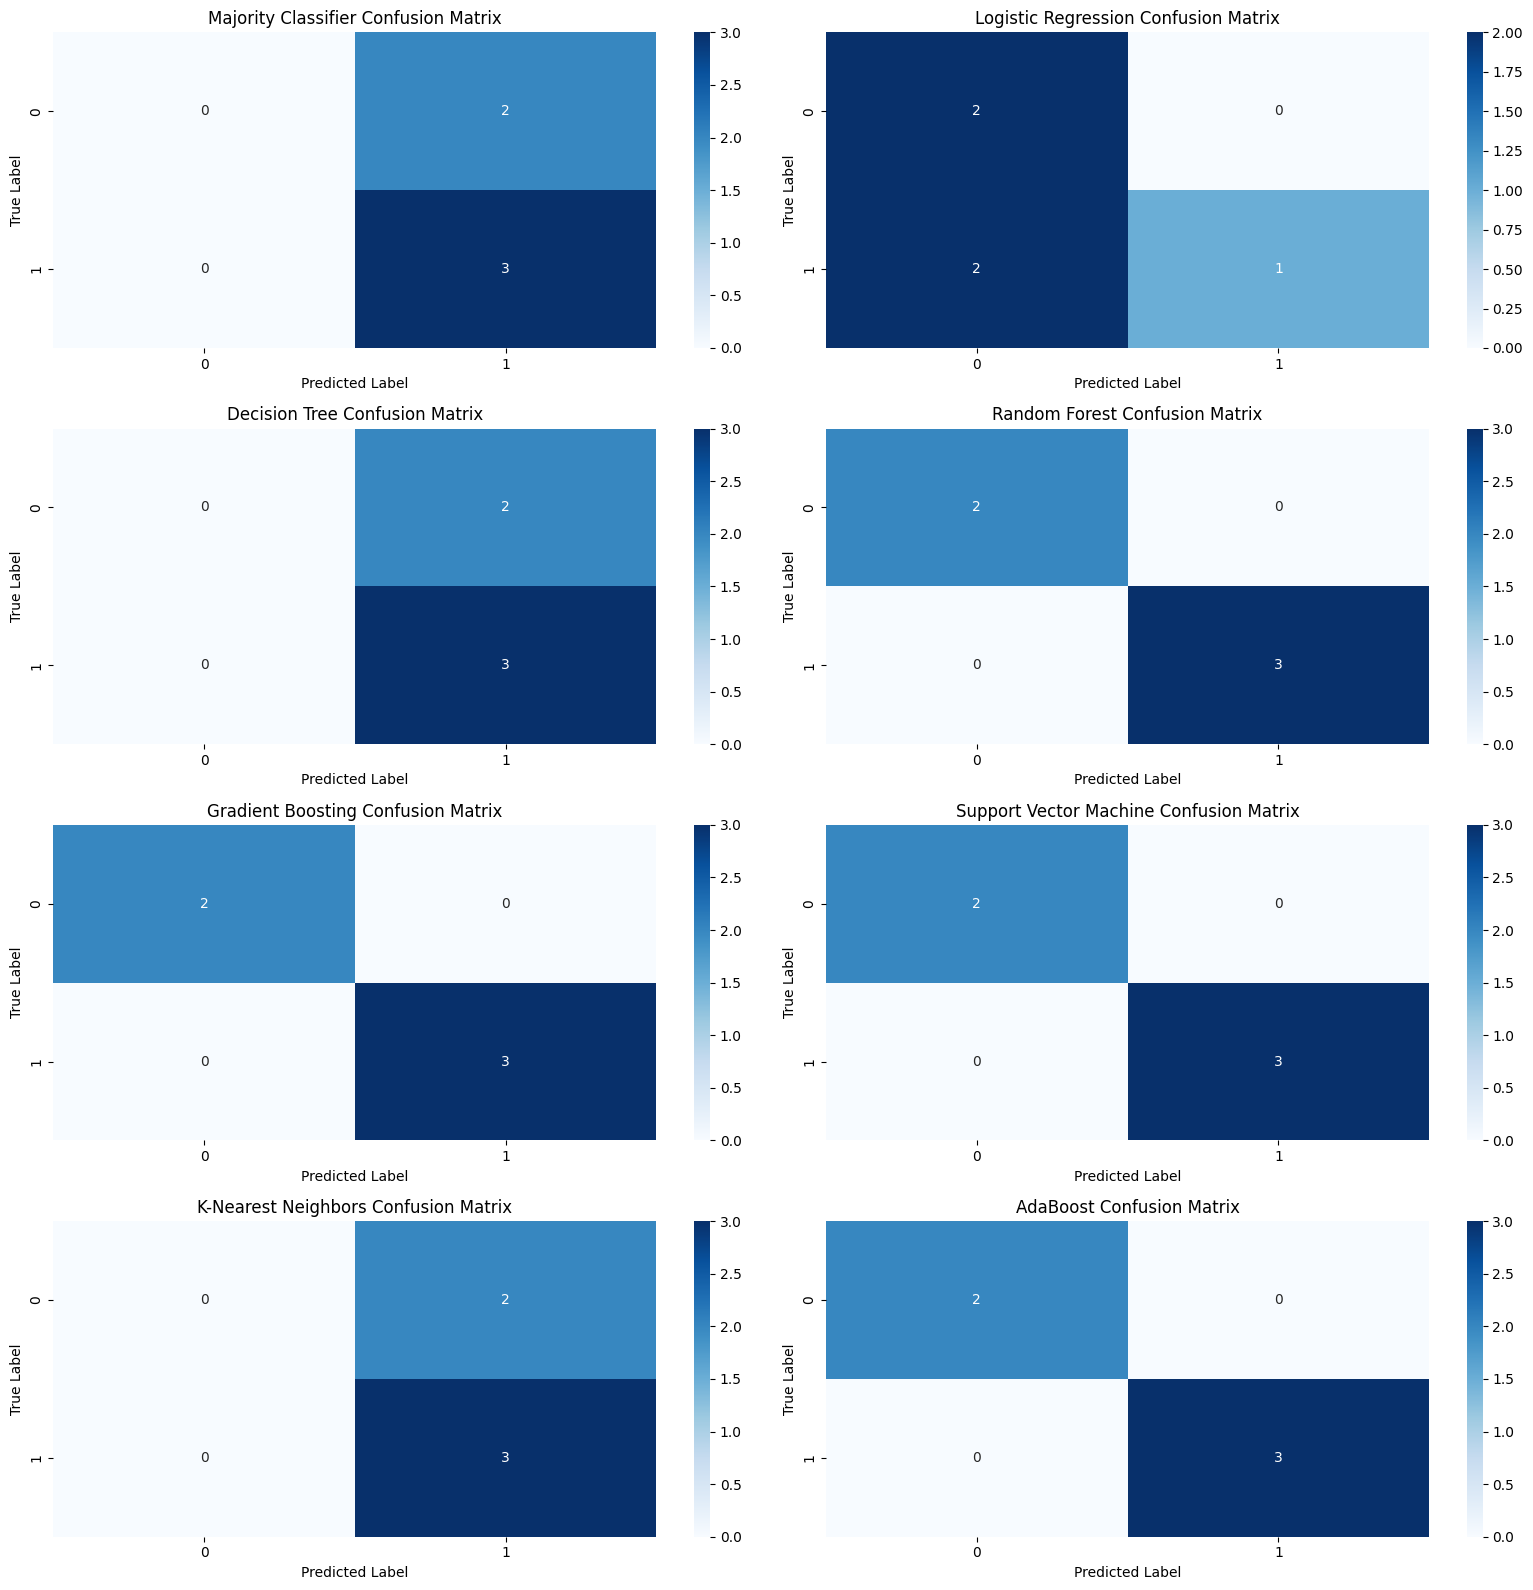

/tmp/ipykernel_35754/426578484.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]


,commercial_number,commercial_number,BDM,Logistic Regression_result,Random Forest_result,Support Vector Machine_result,majority_vote
0,AD0525,AD0525,1.0,FN,TP,TP,TP
1,AD0474,AD0474,0.0,TN,TN,TN,TN
2,AD0357,AD0357,0.0,TN,TN,TN,TN
3,AD0584,AD0584,1.0,FN,TP,TP,TP
4,AD0414,AD0414,1.0,TP,TP,TP,TP



Decision Tree Analysis:


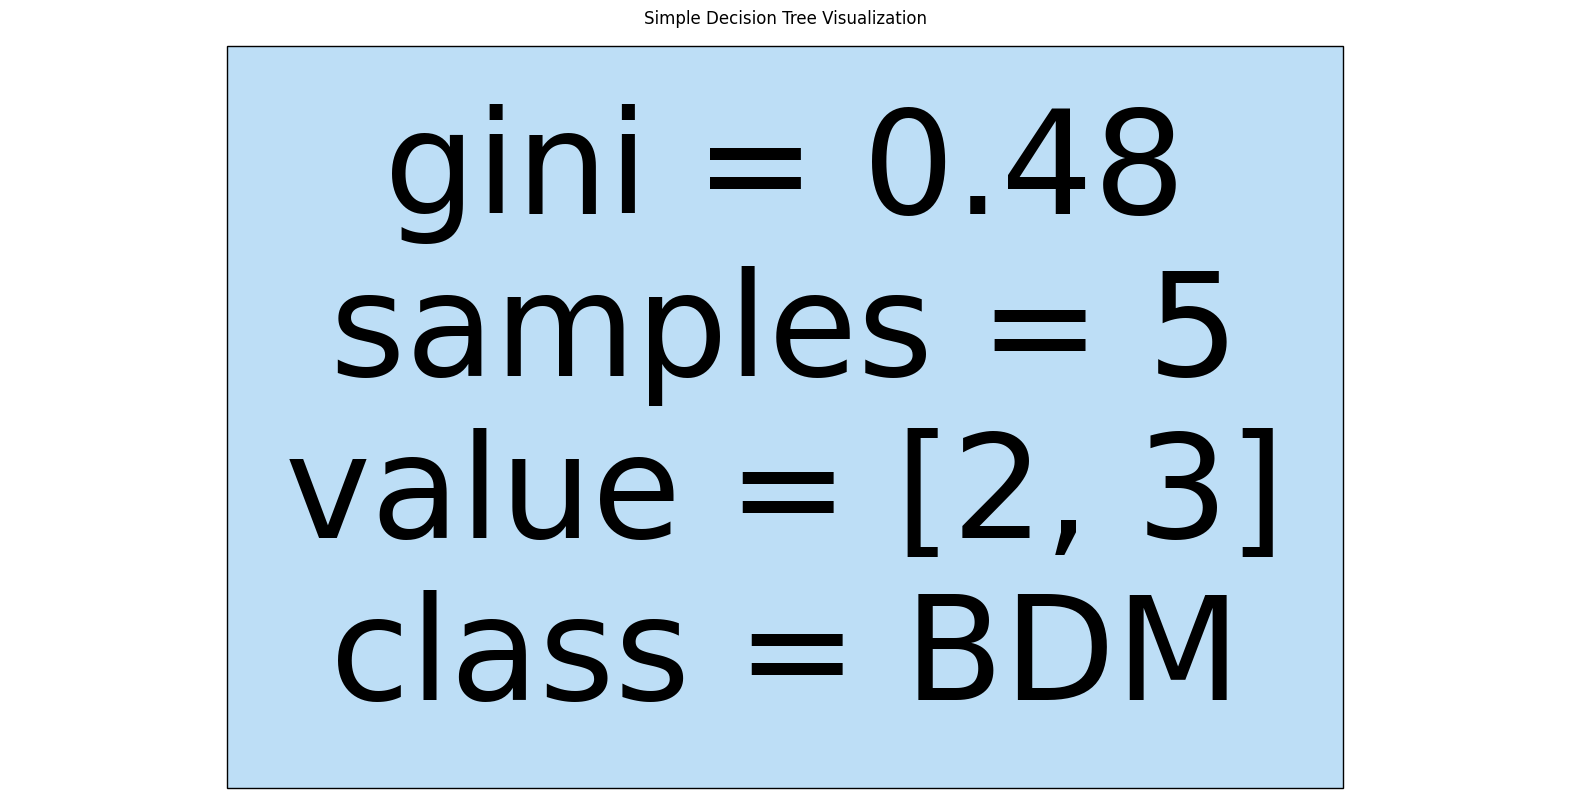


Feature Importance Ranking:
1. num_adj_noun_pairs: 0.000
2. total_bdm_terms_pct: 0.000
3. total_bdm_terms_count: 0.000
4. uniqueness_count: 0.000
5. comparative_count: 0.000
6. superlative_count: 0.000


In [3]:
import models as m

data, target = m.prepare_model_data(ad_df_balanced, INDUSTRY_SPECIFIC_AWARENESS, BRAND_SPECIFIC_AWARENESS)

base_models = m.get_base_models()
param_distributions = m.get_param_distributions()
tuned_models = m.tune_models(data, target, base_models, param_distributions)

trained_models = m.train_models(data, target, tuned_models)

# Evaluate the trained models
results_df, predictions = m.evaluate_models(data, target, trained_models)

original_data = ad_df_balanced.copy()
commercial_number = original_data['commercial_number']
display(original_data.head(10))

original_data = pd.concat([original_data, commercial_number], axis=1)

original_data = pd.concat([original_data, predictions], axis=1)

# After your existing model training code
m.display_model_results(data, target, trained_models, results_df)


predicted_data = original_data

# only include the top 3 models prediction results
predicted_data = predicted_data[['commercial_number', 'BDM', 'Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']]
# write the majority result of the colums logistic regression, random forest and support vector machine to a new column majority vote
predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]
display(predicted_data.head(10))


m.analyze_decision_tree(data, target, tuned_models)


## Ansatz 2 - RNN + LSTM

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

## Ansatz 2 - RNN + LSTM

In [38]:
df = nn_df

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [40]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    
    # Clean the descriptions - replace NaN with empty string and ensure all items are strings
    descriptions = df["description"].fillna("").astype(str).tolist()
    
    # Convert to tensors
    ds = tf.data.Dataset.from_tensor_slices((descriptions, labels))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [42]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

In [44]:
import tf_keras

model = tf_keras.Sequential([
    hub_layer,
    tf_keras.layers.Dense(16, activation='relu'),
    tf_keras.layers.Dropout(0.4),
    tf_keras.layers.Dense(16, activation='relu'),
    tf_keras.layers.Dropout(0.4),
    tf_keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

In [ ]:
model.evaluate(valid_data)

In [48]:
# history = model.fit(train_data, epochs=3, validation_data=valid_data)

In [49]:
# 


In [ ]:
model.evaluate(test_data)

In [51]:
from sklearn.model_selection import KFold

def cross_validate_confusion_matrix(df, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_true = []
    all_pred = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Split the data
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]
        
        # Create datasets
        train_data = df_to_dataset(train)
        val_data = df_to_dataset(val)
        
        # Train model
        model = tf_keras.Sequential([
            hub_layer,
            tf_keras.layers.Dense(16, activation='relu'),
            tf_keras.layers.Dropout(0.4),
            tf_keras.layers.Dense(16, activation='relu'),
            tf_keras.layers.Dropout(0.4),
            tf_keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam',
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
        
        model.fit(train_data, epochs=3, verbose=0)
        
        # Get predictions for this fold's validation set
        val_predictions = model.predict(val_data, verbose=0)
        val_predictions = (val_predictions > 0.5).astype(int)
        
        # Store true labels and predictions
        val_labels = np.concatenate([y for x, y in val_data], axis=0)
        all_true.extend(val_labels)
        all_pred.extend(val_predictions)
    
    return np.array(all_true), np.array(all_pred)

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(true_labels, predictions, title="Model Confusion Matrix"):
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate and print metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nModel Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

In [ ]:
# Get cross-validation results
true_labels, predictions = cross_validate_confusion_matrix(df)

# Plot confusion matrix for all data
plot_confusion_matrix(true_labels, predictions, "Cross-Validated Model Confusion Matrix")

# LSTM

In [54]:
def cross_validate_lstm_confusion_matrix(df, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_true = []
    all_pred = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Split the data
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]
        
        # Create datasets
        train_data = df_to_dataset(train)
        val_data = df_to_dataset(val)
        
        # Create and compile model
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim=len(encoder.get_vocabulary()),
                output_dim=32,
                mask_zero=True
            ),
            tf.keras.layers.LSTM(32, use_cudnn=False),  # Disable cuDNN
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
        
        # Train model
        model.fit(train_data, epochs=5, verbose=0)
        
        # Get predictions for this fold's validation set
        val_predictions = model.predict(val_data, verbose=0)
        val_predictions = (val_predictions > 0.5).astype(int)
        
        # Store true labels and predictions
        val_labels = np.concatenate([y for x, y in val_data], axis=0)
        all_true.extend(val_labels)
        all_pred.extend(val_predictions)
    
    return np.array(all_true), np.array(all_pred)

In [55]:
encoder = tf.keras.layers.TextVectorization(max_tokens=600)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

In [57]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32, use_cudnn=False),  # Disable cuDNN
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [58]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

In [ ]:
model.evaluate(test_data)

In [ ]:
# Get cross-validation results for LSTM
true_labels_lstm, predictions_lstm = cross_validate_lstm_confusion_matrix(df)

# Plot confusion matrix for all data
plot_confusion_matrix(true_labels_lstm, predictions_lstm, "Cross-Validated LSTM Model Confusion Matrix")

<div class="alert alert-block alert-info">
<b>Fazit</b>


Warum performen die ML Modelle besser als die Neural Networks

1. Datensatzgröße:
- 250 Werbespots sind ein sehr kleiner Datensatz für neuronale Netze, die typischerweise Tausende oder Zehntausende von Beispielen benötigen, um effektiv zu lernen


- Feature-Extraktionsansatz bietet eine explizite Struktur, die bei der begrenzten Menge schonmal eine Grundlage schaffen, die die NNs nicht haben

2. Featurequalität vs. Rohtext:
- Unsere handgefertigten Features erfassen domänenspezifisches Wissen darüber, was eine BDM effektiv macht

- Neuronale Netze müssen diese Muster von Grund auf nur aus Rohtext lernen, was mit begrenzten Daten viel schwieriger ist

</div>